**STATISTICAL LEARNING AND NEURAL NETWORKS, A.A. 2022/2023**

**COMPUTER LAB 3** - Principal component analysis

**Duration: 3 hours**

**Introduction:**

Hyperspectral images are scientific images of the Earth, acquired by satellites or aicrafts; rather than having three R/G/B color channels, these images have a lot more “color” components obtained through a fine sampling of the wavelength (hence the name “hyper”-spectral). The 
resulting 3-dimensional dataset has one image (spectral band or “color”) for every sampled wavelength, which represents the measured radiance from each pixel at that specific wavelength. Hyperspectral images are very useful for image analysis. For every pixel at a given spatial position, it is possible to extract a so-called spectral vector, i.e. the 1-dimensional vector of values assumed by that pixel at all wavelengths. Assuming that each pixel is composed of just one substance, the spectral vector represents the radiance of that substance at all the wavelengths that have been 
sampled. Spectral vectors, therefore, can be used to infer which substance is contained in a given pixel – a typical classification problem that has a lot of practical applications in agriculture, analysis of land use / land cover, and other applications related to the study of the environment.


In this lab you will use a real hyperspectral image that has been acquired by the AVIRIS instrument, an airborne hyperspectral imager operated by the NASA. The image represents a scene of Indian Pines (Indiana, USA). It has a size of 145x145 pixels and 220 spectral bands. Along with the image, a ground truth is available, in terms of labels specifying which class (out of 16) each pixel belongs to. The classes are reported below; for more information, please see 
http://www.ehu.eus/ccwintco/index.php/Hyperspectral_Remote_Sensing_Scenes#Indian_Pines

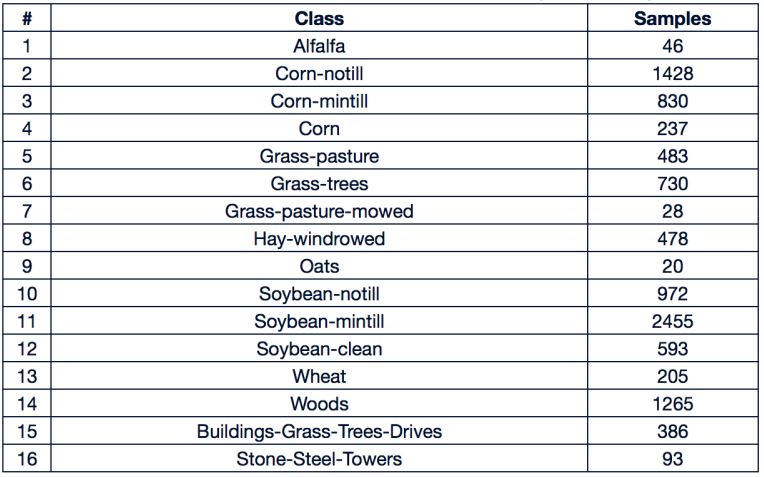

The purpose of this computer lab is twofold:
To apply PCA to the spectral vectors in order to reduce their dimensionality.

*   To apply PCA to the spectral vectors in order to reduce their dimensionality.
*   To perform classification on the reduced data (optional)

**Exercise 1 – PCA**


In this exercise, you will employ the Indian Pines dataset. You will not do this for the entire dataset, but only for the spectral vectors belonging to **two classes** (as in the optional exercise you will perform 2-class classification on the PCA coefficients). 

**Reminder:** the input to the PCA must always have zero mean: besides the sample covariance, you will have to compute the **mean value μ** over the training set and subtract it from each test vector before applying PCA.

**Task:** You have to reduce the dimensionality of the spectral vectors of the two classes you have chosen using PCA. In particular, you should perform the following:


*   Extract spectral vectors of two classes, as described above (see sample code below).
*   Estimate the sample covariance matrix of the dataset as a whole (i.e., considering together spectral vectors of the two classes)
*   Perform the eigenvector decomposition of the sample covariance matrix. You can use the numpy linalg.eig function, which outputs the matrix containing the eigenvectors as columns, and a diagonal matric containing the eigenvalues on the main diagonal.
  * Note: in the output matrix, eigenvectors/eigenvalues are not necessarily ordered by eigenvalue magnitude. You should sort them by yourself.
*   Choose a number of dimensions K<=220.
*   Construct the eigenvector matrix W for K components (i.e., select the last K columns)
*   Using W, compute the PCA coefficients for each spectral vector in the data set
*   Then from the PCA coefficients obtain an approximation of the corresponding vector and compute the error (mean square error - MSE)
*   Plot the average MSE over the test set as a function of K.
*   Plot the eigenvectors corresponding to the 3 largest eigenvalues – this will give you an idea of the basis functions employed by PCA

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import h5py
import scipy.io

mat = scipy.io.loadmat('Indian_pines.mat')
indian_pines = np.array(mat['indian_pines'])  # For

mat = scipy.io.loadmat('Indian_pines_gt.mat')
indian_pines_gt = np.array(mat['indian_pines_gt'])

**Extract spectral vectors of two classes, as described above (see sample code below).**

In [13]:
# Class value is the value (between 1 and 16) of the class we want to consider
class1_value = 4    # Corn

class1 = np.zeros((1500, 220))
n = 0
for i in range(145):
    for j in range(145):
        if indian_pines_gt[i, j] == class1_value:
            class1[n, :] = indian_pines[i, j, :]
            n = n + 1
class1 = class1[:n, :]

class2_value = 14   # Woods

class2 = np.zeros((1500, 220))
n = 0
for i in range(145):
    for j in range(145):
        if indian_pines_gt[i, j] == class2_value:
            class2[n, :] = indian_pines[i, j, :]
            n = n + 1
class2 = class2[:n, :]

In [14]:
# Preparing train and test sets
X = np.concatenate([class1, class2], axis=0)
N = X.shape[0]
D = X.shape[1]

np.random.seed(319244)
np.random.shuffle(X)

percent_train = 0.6
N_train = int(percent_train * N)
N_test = N - N_train
X_train = X[:N_train]
X_test = X[N_train:]

**Estimate the sample covariance matrix of the dataset as a whole (i.e., considering together spectral vectors of the two classes)**

In [15]:
X_train_cov = np.cov(X_train, rowvar=False)

**Perform the eigenvector decomposition of the sample covariance matrix. You can use the numpy linalg.eig function, which outputs the matrix containing the eigenvectors as columns, and a diagonal matrix containing the eigenvalues on the main diagonal.**

In [16]:
from numpy import linalg as LA

avals, U = LA.eig(X_train_cov)
i_order = np.argsort(avals)[::-1]

#Note: in the output matrix, eigenvectors/eigenvalues are not necessarily ordered by eigenvalue magnitude. You should sort them first.

**Choose a number of dimensions K<=220.Construct the eigenvector  matrix W for K components (i.e., select the last K columns)**

In [7]:
K = 200
# v = avals[-K:]
U_k = np.array([U[:, i_order[k]] for k in range(K)]).T

**Using W, compute the PCA coefficients for each spectral vector in the data set. Then from the PCA coefficients obtain an approximation of the corresponding vector and compute the error (mean square error - MSE)**

In [8]:
#Note: remember to remove the mean from the vectors of the dataset
X_train_norm = X_train - X_train.mean(axis=0)

# Computing the latent variables matrix
Z = np.array([U_k.T @ X_train_norm[i] for i in range(N_train)])
# Dataset values estimation
X_train_hat = np.array([U_k @ Z[i] for i in range(N_train)])
# Mean Square Error (as J)
e_MSE = 1 / N * sum(LA.norm(X_train_norm[i] - X_train_hat[i]) ** 2 for i in range(N_train))
print(f'MSE (for K = {K}): {e_MSE}')

MSE (for K = 200): 129.38662096564946


**Plot the average MSE over the test set as a function of K.**

In [9]:
# computing the MSE for each value of K
X_test_norm = X_test - X_train.mean(axis=0)
J = np.empty(D)
for K in range(1, D + 1):
    U_k = np.array([U[:, i_order[k]] for k in range(K)]).T
    Z = np.array([U_k.T @ X_test_norm[i] for i in range(N_test)])
    
    X_test_hat = np.array([U_k @ Z[i] for i in range(N_test)])
    J[K - 1] = 1 / N * sum(LA.norm(X_test_norm[i] - X_test_hat[i]) ** 2 for i in range(N_test))

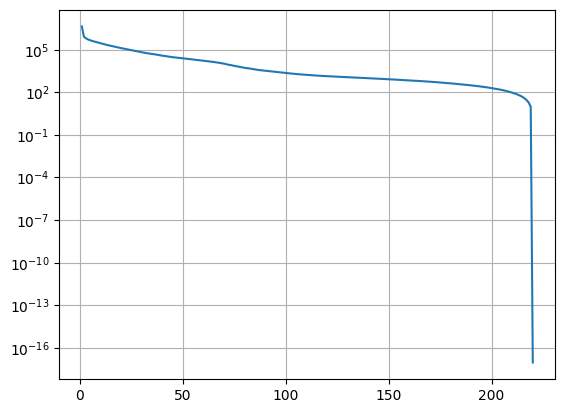

In [10]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(range(1, 220 + 1), J)
plt.yscale('log')
plt.grid()
plt.show()

**Plot the eigenvectors corresponding to the 3 largest eigenvalues – this will give you an idea of the basis functions employed by PCA**

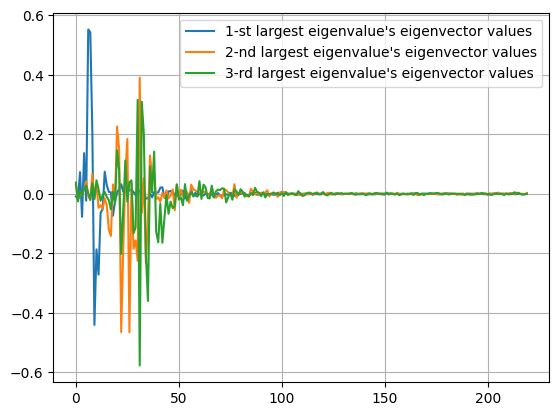

In [11]:
plt.figure()
plt.plot(U[i_order[0]])
plt.plot(U[i_order[1]])
plt.plot(U[i_order[2]])
labels = ['1-st largest eigenvalue\'s eigenvector values', '2-nd largest eigenvalue\'s eigenvector values', '3-rd largest eigenvalue\'s eigenvector values']
plt.legend(labels)
plt.grid()
plt.show()

**Student's comments to Exercise 1**

*Add comments to the results of Exercise 1 here (may use LateX for formulas if needed).*

**Exercise 2 – Classification using dimensionality reduction and whitening (optional)**

In this exercise you will apply a simple 2-class linear discriminant analysis (LDA) classifier to the data belonging to the two classes, before and after **whitening** (i.e. applying PCA plus rescaling 
each coefficient to unit variance: $y = \Lambda^{-\frac{1}{2}}W^{T}x$. Note that matrix $\Lambda$ is obtained as one of the outputs of *eig.m*). This classifier makes the Naïve Bayes Classifier assumption that the features are statistically independent, thus the shared covariance matrix is taken as $\Sigma = I$. We also assume that class 0 and class 1 are equiprobable. Thus, letting $\mu_{0}$ and $\mu_{1}$ be the mean of vectors in class 0 and 1, we define $x_{0} = 0.5(\mu_{0} + \mu_{1})$ and $w = \mu_{1}-\mu_{0}$. A test vector $x$ is classified into class 1 or 0 depending on whether $sign(w^{T}(x − x_{0}))$ is equal to +1 or -1.

When the classifier is applied to the PCA coefficients, you simply replace $\mu_{0}$ and $\mu_{1}$ with their reduced versions (subtracting $\mu$ and applying the same PCA matrix computed over the training set), and recalculate $x_{0}$ and $w$ accordingly.

**Task:** Divide the Indian Pines dataset into training and test sets (e.g. 75% of the data of each class to be used as training data, and 25% as test data). Train this classifier on the training data, and 
apply it to the test data. In particular, you should perform the following:
*   Plot the mean vector of class 0 and 1 – this will give you a visual description of the differences among vectors of either class.
*   Apply the classifier to the original data (without PCA) and compute its accuracy
*   Apply the classifier to the PCA coefficients for different values of K, and compute its accuracy
*   Apply the classifier to the original data where only the first K features have been retained, and compute its accuracy (this is a more brutal way to reduce dimensionality)
*   Try to classify the data using a Support Vector Machine and compare the results





**Plot the mean vector of class 0 and 1 – this will give you a visual description of the differences among vectors of either class.**

In [6]:
#Insert code here
# Lambda, W = LA.eig(X_train_cov)

**Apply the classifier to the original data (without PCA) and compute 
its accuracy**

In [7]:
#For this section you can use the code you developed for the previous Lab or the sklearn function LinearDiscriminantAnalysis

**Apply the classifier to the PCA coefficients for different values of K, and compute its accuracy** 

In [8]:
#Insert code Here

**Apply the classifier to the original data where only a subset of K features (selected randomly) have been retained, and compute its accuracy (this is a more brutal way to reduce dimensionality)** 

In [9]:
#Insert code here

**Try to classify the data using a Support Vector Machine and compare the results**

In [10]:
#For this section you can use the sklearn library 

#from sklearn import svm

#svc = svm.SVC()
#svc.fit(Train, Train_Label)
#predict = svc.predict(Test)

#print(metrics.accuracy_score(predict, Test_Label))

**Student's comments to Exercise 2**

*Add comments to the results of Exercise 2 here (may use LateX for formulas if needed).*